### Import Numpy

In [158]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Create GBM Object

In [110]:
class GBM:
    
    def __init__(self, X, y, predict_fn, score_fn, max_depth = 3, n_trees = 5):
    
        self.trees = []
        self.errors = []
        self.trees.append(Tree(X, y, predict_fn, score_fn, max_depth))
        
        for i in range(1, n_trees):
            if i % 20 == 0: print('Creating tree '+ str(i))
            error = self.get_error_term(i - 1, X, y)
            self.errors.append(error)
            self.trees.append(Tree(X, error, predict_fn, score_fn, max_depth))

    def __str__(self):
        return 'A GBM model with ' + str(len(self.trees)) + ' trees'
    
    def predict_ith_tree(self, ith_tree, X):
        preds = np.zeros(X.shape[0])
        for i in range(ith_tree + 1):
            preds = preds + self.trees[i].predict(X)
        return preds
    
    def predict(self, X):
        return self.predict_ith_tree(len(self.trees) - 1, X)
    
    def get_error_term(self, i, X, y):
        return y - self.predict_ith_tree(i, X)

### Create Tree Object

In [24]:
class Tree:
    
    def __init__(self, X, y, predict_fn, score_fn, max_depth = 3):
        self.rootNode = Node('Root', X, y, predict_fn, score_fn,
                             idxs = np.arange(len(y)), max_depth = max_depth, current_depth = 0)
        
    def predict(self, X):
        return self.rootNode.predict(X)
    
    def __str__(self):
        return self.rootNode.__str__()

### Create Node Object

In [25]:
class Node:
    
    def __init__(self, name, X, y, predict_fn, score_fn, idxs, max_depth, current_depth):
        

        self.name = name
        self.X = X[idxs, :]
        self.y = y[idxs]
        self.predict_fn = predict_fn
        self.score_fn = score_fn
        self.idxs = idxs
        self.num_rows = self.X.shape[0]
        self.num_cols = self.X.shape[1]
        self.score = float('inf')
        self.split_col_idx = 0
        self.split_value = None
        self.max_depth = max_depth
        self.current_depth = current_depth
        
        self.current_depth += 1
        if self.current_depth > self.max_depth:
            return
        
        self.find_best_split()
        self.create_child_nodes()
        
        
        
    def find_best_split(self):
        for col in range(self.num_cols):
            for row in range(self.num_rows):
                if self.calculate_score(self.X[row, col], col) < self.score:
                    self.score = self.calculate_score(self.X[row, col], col)
                    self.split_col_idx = col
                    self.split_value = self.X[row, col]
      
    def calculate_score(self, value, col_idx):
        return self.score_fn(self.X, self.y, value, col_idx)
    
    def create_child_nodes(self):
        
        lhs_idx = np.where(self.X[:, self.split_col_idx] <= self.split_value)[0]
        rhs_idx = np.where(self.X[:, self.split_col_idx] > self.split_value)[0]
        
        if len(lhs_idx) == 0 or len(rhs_idx) == 0:
            self.score = float('inf')
            return
        
        self.lhn = Node(self.name + ' - Left', self.X, self.y, self.predict_fn, self.score_fn,
                        lhs_idx, self.max_depth, self.current_depth)
        self.rhn = Node(self.name + ' - Right', self.X, self.y, self.predict_fn, self.score_fn,
                        rhs_idx, self.max_depth, self.current_depth)
        
    def predict_row(self, new_X_i):
        if self.score == float('inf'):
            return self.predict_fn(self.y)
        else:
            if new_X_i[self.split_col_idx] <= self.split_value:
                return self.lhn.predict_row(new_X_i)
            else:
                return self.rhn.predict_row(new_X_i)
            
    def predict(self, new_X):
        return [self.predict_row(new_X[i]) for i in range(new_X.shape[0])]
    
    def __str__(self):
        if self.score == float('inf'):
            return ('\n' + '  ' * (self.current_depth - 1) + 'Rows: ' + str(self.num_rows) +
                   ' - Prediction: ' + str(self.predict_fn(self.y)))
        else:
            return ('\n' + '  ' * (self.current_depth - 1) + 'Rows: ' + str(self.num_rows) +
                    ' - Split Col: ' + str(self.split_col_idx) + ' - Split Value: ' + str(self.split_value) +
                    ' - Score: ' + str(self.score) + self.lhn.__str__() + self.rhn.__str__())

### Create Scoring Function

In [26]:
def find_rmse(X, y, value, col_idx):
    lhs = np.where(X[:, col_idx] <= value)[0]
    rhs = np.where(X[:, col_idx] > value)[0]
    
    lhs_mean = predict_mean(y[lhs])
    rhs_mean = predict_mean(y[rhs])
    
    preds = np.zeros(len(y))
    preds[lhs] = lhs_mean
    preds[rhs] = rhs_mean
    
    return np.sqrt(np.mean((y - preds) ** 2))

### Create Prediction Logic Function

In [27]:
def predict_mean(y):
    return np.mean(y)

### Import Data

In [112]:
iris = datasets.load_iris() # Classification
wine = datasets.load_wine() # Classification
breast_cancer = datasets.load_breast_cancer() # Classification
boston = datasets.load_boston() # Regression
diabetes = datasets.load_diabetes() # Regression

train_X, test_X, train_y, test_y = train_test_split(boston['data'], boston['target'],
                                                    test_size = .5, random_state = 0)


### Train and Test Model

In [166]:
gbm = GBM(train_X, train_y, predict_mean, find_rmse, max_depth = 2, n_trees = 34)

print(gbm)

print(gbm.predict(test_X))
print(test_y)

np.sqrt(np.mean((gbm.predict(test_X) - test_y) ** 2))
# np.mean(gbm.predict(test_X) == test_y)

Creating tree 20
A GBM model with 34 trees
[26.02364577 21.28797555 24.25538649  6.71115251 20.00723703 19.27957926
 22.06345277 19.92410668 24.75069293 19.20207995  9.48565438 11.18991092
 13.5877168   5.41043589 48.91817922 40.74266091 20.01916473 37.33336625
 26.93694466 22.05568431 23.19569217 23.47642362 21.56157515 26.60423867
 22.53266034 17.44203137 18.51141626 15.88977861 39.61932203 19.8922516
 16.76839385 20.59538671 18.29395798 21.13189456 26.38543994 20.36375507
  7.33803702 19.99047704 14.43875409 14.6128849  24.99934116 21.73360356
 21.96728015 14.83444719 23.33044637 20.0995609  18.39323267 14.44395322
 15.9005347  22.34889647 17.54629226 19.82123205 22.18405283 42.36726621
 12.040815   18.36584156 19.39576218 17.64299674 13.36258914 20.68840183
 27.75327    23.3267571  31.10105879 32.50719747 21.57382064 35.90711118
 19.01326638 18.50519851 10.07915584 25.01452496 19.88100085 21.27078335
 26.62464962 32.33024219 27.39459338  5.87242312 41.56557069 24.36003661
 23.13937

5.061892880830706

Model 0
Model 2
Model 4
Model 6
Model 8
Model 10
Model 12
Model 14
Model 16
Model 18
Model 20
Model 22
Creating tree 20
Model 24
Creating tree 20
Model 26
Creating tree 20
Model 28
Creating tree 20
Model 30
Creating tree 20
Model 32
Creating tree 20
Model 34
Creating tree 20
Model 36
Creating tree 20
Model 38
Creating tree 20


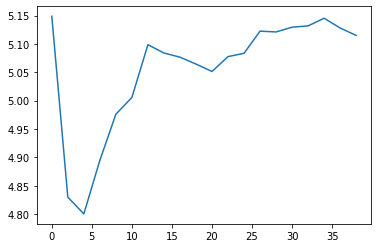

In [167]:
data = []
for i in range(0, 40, 2):
    print('Model ' + str(i))
    gbm = GBM(train_X, train_y, predict_mean, find_rmse, max_depth = 3, n_trees = i)
    data.append(np.sqrt(np.mean((gbm.predict(test_X) - test_y) ** 2)))
    
plt.plot([i for i in range(0, 40, 2)], data)